# Критерий Вальда, две простых гипотезы

Полезные ссылки:
- https://www.youtube.com/watch?v=4NYbTUIkBbU&index=4&list=PLlb7e2G7aSpRG_Ve6kuxc9Biuwyf42kJx
- https://en.wikipedia.org/wiki/Sequential_probability_ratio_test

Пусть $X_{[i]}=(X_1, X_2, ..., X_i)$ - выборка, 

Сформулируем две гипотезы:

$H_0: F_\xi=F_0$
$H_1: F_\xi=F_1$, построим

Отношение функций правдоподобия

$$Z(X_{[i]}) = \frac{L(X_{[i]}, F_1)}{L(X_{[i]}, F_0)}, \mathbf{где } L(X_{[i]}, F_0)=\prod_{k=1}^{i}f_0(X_k)$$

Зададим две границы:

$$c_0 \le Z(X_{[i]}) \le c1 $$

При выходе за $c_0$ - принимаем $H_0$, при выходе за $c_1$ принимаем $H_1$, иначе продолжаем эксперименты.

### Выбор констант

$$ 0 < c_0 < 1 < c_1 < \inf $$
$$ \alpha \le \frac{1-\beta}{c_1} \le \frac{1}{c_1} $$
$$ \beta \le (1-\alpha)c_0 \le c_0 $$

Тогда можно приблизить:

$$\tilde{c}_0 = \frac{\beta}{1 - \alpha}, \tilde{c}_1 = \frac{1-\beta}{\alpha} $$


# Libs

In [0]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import math
import matplotlib.pyplot as plt

# Funcs

Создадим функцию для генерации генеральной совокупности, полученной путём смешивания выборок из нормальных распределений с разными параметрами. 

In [0]:
'''
Функция простого случайного выбора. Возвращает массив размера size. 
Согласно весам распределений weights случайно выбирается одно из трёх распределений. 
Из выбранного распределения (согласно параметрам распределения из датафрейма distributions) 
выбирается случайное значение, которое и записывается в выборку.
'''


def simple_random_sampling(size, weights, distributions):

    sample = []
    choices = []

    #Выбираем распределения случайным образом согласно вероятностям из листа weights
    choices.extend(np.random.choice(range(len(weights)), size=size, p=weights))

    for i in range(len(weights)):
        #Добавляем в лист случайные значения из i-ого распределения согласно его доле
        sample.extend(
            np.random.normal(loc=distributions.at[i, 'mean'],
                             scale=distributions.at[i, 'std'],
                             size=choices.count(i)))

    #Так как элементы в ПКОП обрабатываются по порядку, обязательно их перемешаем,
    #чтобы при начале работы функции не обрабатывались элементы только
    #из одного распределения
    sample = np.array(sample)
    np.random.shuffle(sample)
    return sample

In [0]:
'''
Функция последовательного критерия отношения правдоподобий (SPRT).
Функция проводит наблюдения над элементами выборки sample
до первого элемента sample[i], при котором можно принять гипотезу H0 или H1,
которым соответствуют распределения D0 и D1.
Гипотезы проверяются для заданных ошибок 1-го и 2-го рода
'''


def wald_test(sample, D0, D1, alpha, beta):

    c_0, c_1 = bounds_approximation(alpha, beta)

    Z = D1.pdf(sample[0]) / D0.pdf(sample[0])

    i = 1
    while (c_0 <= Z <= c_1 and i < len(sample)):
        Z *= D1.pdf(sample[i]) / D0.pdf(sample[i])
        i += 1

    if Z < c_0:
        return 0, i
    elif Z > c_1:
        return 1, i
    else:
        return -1

Создадим функцию аппроксимации границ c0, c1 согласно лемме ![alt text](lemma.png "Title")

In [0]:
def bounds_approximation(alpha, beta):

    #левая граница
    c_0 = beta / (1 - alpha)
    #правая граница
    c_1 = (1 - beta) / alpha

    return c_0, c_1

Для выяснения, не менее скольки наблюдений в среднем необходимо провести при использовании ПКОП силы (α,β), в случае справедливости нулевой гипотезы, была написана функция

In [0]:
'''
Функция проводит iterations экспериментов с выборками размера size.
Выводит количество экспериментов, в которых была принята нулевая гипотеза,
а также среднее количество шагов до принятия нулевой гипотезы
'''


def count_steps_null_hyp(size, weights, distributions, D0, D1, alpha, beta,
                         iterations):
    steps = []
    null_accepted = 0

    for i in range(iterations):
        sample = simple_random_sampling(size, weights, distributions)
        res, step = wald_test(sample, D0, D1, alpha, beta)
        if (res == 0):
            null_accepted += 1
            steps.append(step)

    print("Нулевая гипотеза принята {} раз из {}\n\
Среднее количество шагов до принятия гипотезы: {}".format(
        null_accepted, iterations,
        np.asarray(steps).mean()))

# Wald test usage

## Different weight

Определение параметров задачи

In [0]:
#Зададим доли страт нормальных распределений в генеральной совокупности
weight_0 = 0.1
weight_1 = 0.7
weight_2 = 0.2

weights = [weight_0, weight_1, weight_2]

#Зададим параметры нормально распределённых случайных величин
data = {'mean': [0, 5, 10], 'std': [1, 2, 3]}
distributions = pd.DataFrame(data=data)
D0 = stats.norm(distributions['mean'][0], distributions['std'][0])
D1 = stats.norm(distributions['mean'][1], distributions['std'][1])
D2 = stats.norm(distributions['mean'][2], distributions['std'][2])

# Зафиксируем ошибку 1-го и максимально желаемую ошибку 2-го рода
alpha = 0.001
beta = 0.001

Сгенерируем синтетические данные путем смешивания выборок из нормальных распределений с разными параметрами

In [0]:
sample = simple_random_sampling(5000, weights, distributions)

Выведем гистограмму с соответствующей функцией плотности вероятности

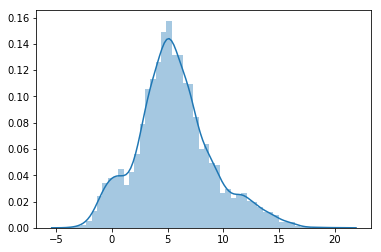

In [0]:
sns.distplot(sample)
plt.show()

### Применим ПКОП (критерий Вальда) силы (0.001, 0.001) для D1 и D0. Им соответствуют гипотезы H0 и Н1. Нулевая гипотеза была выбрана из предположения о том, что г.с. подчиняется распределению с доминирующим весом (доля распределения D1 равна 0.7)

In [0]:
res, steps = wald_test(sample, D1, D0, alpha, beta)
if res == 0:
    print('Гипотеза H0 принята после {} шагов'.format(steps))
elif res == 1:
    print('Гипотеза H1 принята после {} шагов'.format(steps))
else:
    print('Выход за границы выборки')

Гипотеза H0 принята после 2 шагов


Доля распределения D1 подавляющая, и распределения D0 и D2, находящиеся по обе стороны от D1, не вносят заметного вклада. Поэтому, как и ожидалось, после небольшого количества шагов была принята нулевая гипотеза (г.с. подчиняется закону распределения D1)

Проведём тысячу экспериментов для выборок размером 1000 элементов с целью удостовериться, что почти всегда принимается нулевая гипотеза (распределение D1) и что количество шагов для принятия решения достаточно мало

In [0]:
count_steps_null_hyp(1000, weights, distributions, D1, D0, alpha, beta, 1000)

Нулевая гипотеза принята 987 раз из 1000
Среднее количество шагов до принятия гипотезы: 1.4397163120567376


### Применим ПКОП (критерий Вальда) силы (0.001, 0.001) для D1 и D2. Им соответствуют гипотезы H0 и Н1. Нулевая гипотеза выбрана из того же предположения, что и в предыдущем пункте

In [0]:
res, steps = wald_test(sample, D1, D2, alpha, beta)
if res == 0:
    print('Гипотеза H0 принята после {} шагов'.format(steps))
elif res == 1:
    print('Гипотеза H1 принята после {} шагов'.format(steps))
else:
    print('Выход за границы выборки')

Гипотеза H0 принята после 5 шагов


In [0]:
count_steps_null_hyp(1000, weights, distributions, D1, D2, alpha, beta, 1000)

Нулевая гипотеза принята 799 раз из 1000
Среднее количество шагов до принятия гипотезы: 7.022528160200251


При сравнении распределений D2 и D1 ситуация похожая, но количество шагов и доля принятых альтернативных гипотез увелчиваются ввиду большей схожести распределений D2 и D1 (по сравнению с D1 и D0)

#### Ради эксперимента попробуем уменьшить ошибки первого и второго рода. Ожидаем увеличение количества шагов, так как левый порог, с которым сравнивается  отношение функций правдоподобия уменьшится, а правый-увеличится.

In [0]:
alpha = 0.00001
beta = 0.00001

res, steps = wald_test(sample, D1, D2, alpha, beta)
if res == 0:
    print('Гипотеза H0 принята после {} шагов'.format(steps))
elif res == 1:
    print('Гипотеза H1 принята после {} шагов'.format(steps))
else:
    print('Выход за границы выборки')

Гипотеза H0 принята после 7 шагов


In [0]:
count_steps_null_hyp(1000, weights, distributions, D1, D2, alpha, beta, 1000)

Нулевая гипотеза принята 871 раз из 1000
Среднее количество шагов до принятия гипотезы: 14.318025258323766


## Equal weights
Теперь попробуем изменить доли распределений в генеральной совокупности. Сделаем их равными

In [0]:
weight_0 = 0.33
weight_1 = 0.33
weight_2 = 0.34

weights = [weight_0, weight_1, weight_2]

alpha = 0.001
beta = 0.001

In [0]:
sample = simple_random_sampling(5000, weights, distributions)

Выведем гистограмму с соответствующей функцией плотности вероятности

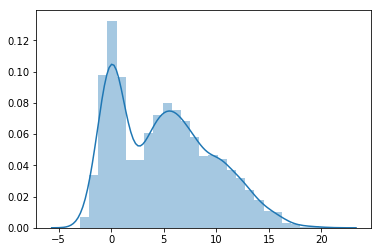

In [0]:
sns.distplot(sample)
plt.show()

Видим, что с уменьшением преобладания распределения D1, стало более заметно влияние на г.с. распределений D0 и D2

### Применим по очереди ПКОП (критерий Вальда) силы (0.001, 0.001) для пар: D0 и D1; D1 и D2;  D0 и D2. Нулевая гипотеза: г.с. подчиняется первому распределению из пары

In [0]:
count_steps_null_hyp(1000, weights, distributions, D0, D1, alpha, beta, 1000)

Нулевая гипотеза принята 75 раз из 1000
Среднее количество шагов до принятия гипотезы: 2.4266666666666667


In [0]:
count_steps_null_hyp(1000, weights, distributions, D1, D2, alpha, beta, 1000)

Нулевая гипотеза принята 682 раз из 1000
Среднее количество шагов до принятия гипотезы: 6.706744868035191


In [0]:
count_steps_null_hyp(1000, weights, distributions, D0, D2, alpha, beta, 1000)

Нулевая гипотеза принята 235 раз из 1000
Среднее количество шагов до принятия гипотезы: 1.702127659574468


Видим, что при выравнивании весов в г.с. стали отчётливо выделяться все три её составляющие. Так как среднее D1 находится между средними D0 и D2, а стандартные отклонения относительно большие, распределения заметно пересекаются, и поэтому по критерию Вальда чаще устанавливается, что г.с. распределена согласно закону D1